# Goal of this notebook is: 

to test the performance of several models. 
* A sklearn's DummyClassifier with strategy='most_frequent' will be used as a baseline. 
* Keras' Embedding Layer, GloVe for pre-trained word embeddings, an LSTM and a 1D ConvNet will be used as potential main models.
* Performance metrics are accuracy, precision and recall.

### Disclaimer: this notebook is from an early stage of the project. As a result it exhibits less structure, but it is kept to demonstrate the models before any tuning. 

* for final choice see Notebook 02_2_NLP_Exploration_Models_with_TF

# Import Libraries

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import tensorflow as tf

from collections import Counter
from imblearn.over_sampling import SMOTE
from keras import layers
from keras import models
from keras import regularizers
from keras import utils
from keras.utils import to_categorical
from tensorflow import keras

%matplotlib inline

# Preparation Steps

In [2]:
# folders
home = os.getenv("HOME")
nlp_repo = os.path.join(home, 'git/nlp-product-sentiment-classification')

# data
train_csv_path = os.path.join(nlp_repo, 'data/03_processed/Train.csv')
train_descr = pd.read_csv(train_csv_path)

test_csv_path = os.path.join(nlp_repo, 'data/03_processed/Test.csv')
test_descr = pd.read_csv(test_csv_path)

# encoded tokens
preprocessed_corpus_path_TF = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF.p')

preprocessed_corpus_path_TF_oh = os.path.join(
    nlp_repo, 'data/03_processed/product_descr_preprocessed_TF_oh.p')

In [3]:
# read-in the list of tokens and the vocabulary
sequences, word_index = pd.read_pickle(preprocessed_corpus_path_TF)

# Parameters

In [4]:
# Embedding Tokens

# max_words = vocabulary size = our samples - number of most frequent words.
# For this case, it is set to 10.000, although the data set at hand has less.
# This is done to parametise the code.
# Aleternatively, it can be set to the length of our vocabulary = word_index
max_words = 10000

# embedding_size = embedding dimensionality
embedding_size = 10

# max_len = sequence length - the text is cut off after this number of words
# in this case I define it as the maximum sequence length in our list of tokenised sequences
max_len = np.max([len(x) for x in sequences])


# Training parameters
model_path = "product_descr_TF.h5"
epochs = 15
batch_size = 28

# For GloVe word-embeddings matrix (pre-trained model)
embedding_dim = 100

In [5]:
data = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_len)

In [6]:
labels = train_descr.loc[:, 'Sentiment'].to_list()

In [7]:
data.shape

(6364, 25)

### Oversampling the Minortiy Classes

In [8]:
def oversample_smote(data, labels):
    oversample = SMOTE()
    data, labels = oversample.fit_resample(data, labels)

    counter = Counter(labels)
    for k, v in counter.items():
        per = v / len(labels) * 100
        print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    plt.bar(counter.keys(), counter.values())
    plt.show()

    return data, labels

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


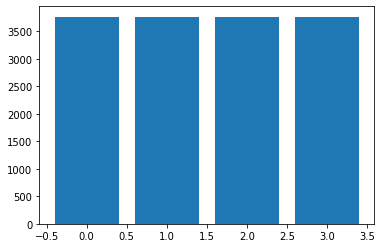

In [9]:
data_ovs, labels_ovs = oversample_smote(data, labels)

In [10]:
dimensions_labels = len(np.unique(labels_ovs))

In [11]:
labels_encoded = tf.one_hot(indices=labels_ovs, depth=dimensions_labels)

In [12]:
labels_encoded = np.asarray(labels_encoded)

In [13]:
print('Shape of data_ovs tensor:', data_ovs.shape)
print('Shape of label_ovs tensor', labels_encoded.shape)

Shape of data_ovs tensor: (15060, 25)
Shape of label_ovs tensor (15060, 4)


In [14]:
indices = np.arange(data_ovs.shape[0])
np.random.shuffle(indices)

In [15]:
data_ovs = data_ovs[indices]
labels_encoded = labels_encoded[indices]

In [16]:
training_samples = int(0.8 * len(data_ovs))

In [17]:
x_train = data_ovs[:training_samples]
y_train = labels_encoded[:training_samples]

x_val = data_ovs[training_samples:]
y_val = labels_encoded[training_samples:]

In [18]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
        if val == value:
            return key

    return "key doesn't exist"

In [19]:
get_key(word_index, 2)

'sxsw'

# Baseline Model

Source: https://machinelearningmastery.com/imbalanced-multiclass-classification-with-the-glass-identification-dataset/

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

In [21]:
model = DummyClassifier(strategy='most_frequent')

In [22]:
cv_test = KFold(n_splits=4, shuffle=True, random_state=1)
scores_test = cross_val_score(
    model, data, labels, scoring='accuracy', cv=cv_test, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' %
      (np.mean(scores_test), np.std(scores_test)))

Mean Accuracy: 0.592 (0.005)


# Bag-of-Words

* Its advantages are that it is fairly easy and quick to build. 
* The downside is that bag-of-words does not perserve the order of the sentence. As a result the structure of a sentence is lost. 
* RNNs & 1D ConvNets will be tried later in order to remedy this.

In [23]:
sequences_oh, word_index_oh = pd.read_pickle(preprocessed_corpus_path_TF_oh)

In [24]:
sequences_oh.shape

(6364, 10000)

Class=2, n=3765 (25.000%)
Class=1, n=3765 (25.000%)
Class=3, n=3765 (25.000%)
Class=0, n=3765 (25.000%)


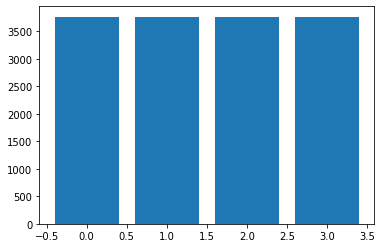

In [25]:
sequences_oh, labels_oh = oversample_smote(sequences_oh, labels)

In [26]:
sequences_oh.shape

(15060, 10000)

In [27]:
labels_encoded_oh = tf.one_hot(indices=labels_oh, depth=dimensions_labels)

In [28]:
data_oh = sequences_oh[indices]

In [29]:
training_samples_oh = int(0.8 * len(data_oh))

In [30]:
x_train_oh = data_oh[:training_samples_oh]
y_train_oh = labels_encoded_oh[:training_samples_oh]

x_val_oh = data_oh[training_samples_oh:]
y_val_oh = labels_encoded_oh[training_samples_oh:]

In [31]:
metrics = [
    keras.metrics.CategoricalAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')]

# Fully Connected NN & Bag-of-Words

In [32]:
model_bow = models.Sequential()

model_bow.add(layers.Dense(32, activation='relu',
                           input_shape=(max_words, )))
# model_bow.add(layers.Dropout(0.5))
model_bow.add(layers.Dense(32, activation='relu'))
# model_bow.add(layers.Dropout(0.5))
model_bow.add(layers.Dense(dimensions_labels, activation='softmax'))

model_bow.summary()

model_bow.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 321,220
Trainable params: 321,220
Non-trainable params: 0
_________________________________________________________________


In [33]:
history_bow = model_bow.fit(
    x_train_oh, y_train_oh,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val_oh, y_val_oh)
)

Epoch 1/15
431/431 [==============================] - 1s 3ms/step - loss: 1.3588 - accuracy: 0.3067 - precision: 0.6667 - recall: 1.6600e-04 - val_loss: 1.6689 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 1.3256 - accuracy: 0.3625 - precision: 0.4528 - recall: 0.0060 - val_loss: 1.7142 - val_accuracy: 0.0256 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 1.2543 - accuracy: 0.4248 - precision: 0.6048 - recall: 0.0843 - val_loss: 1.8218 - val_accuracy: 0.0837 - val_precision: 0.0564 - val_recall: 0.0073
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 1.1624 - accuracy: 0.4732 - precision: 0.6771 - recall: 0.1942 - val_loss: 1.9481 - val_accuracy: 0.0890 - val_precision: 0.0834 - val_recall: 0.0226
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 1.0829

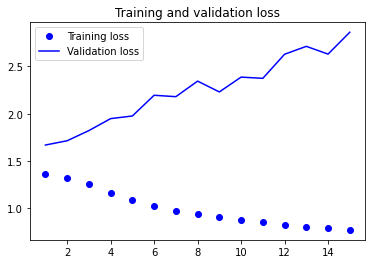

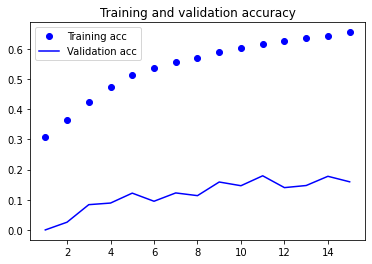

In [34]:
loss_bow = history_bow.history['loss']
val_loss_bow = history_bow.history['val_loss']
acc_bow = history_bow.history['accuracy']
val_acc_bow = history_bow.history['val_accuracy']


epochs_graph = range(1, len(acc_bow) + 1)

plt.plot(epochs_graph, loss_bow, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_bow, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_bow, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_bow, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Embeddings Layer

In [35]:
model_emb = models.Sequential()

model_emb.add(layers.Embedding(max_words+1,
                               embedding_size, input_length=max_len))
model_emb.add(layers.Flatten())
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(32, activation='relu'))
# model_emb.add(layers.Dropout(0.75))
model_emb.add(layers.Dense(dimensions_labels, activation='softmax'))

model_emb.summary()

model_emb.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 10)            100010    
_________________________________________________________________
flatten (Flatten)            (None, 250)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8032      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 109,230
Trainable params: 109,230
Non-trainable params: 0
_________________________________________________________________


In [36]:
history_emb = model_emb.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 1s 3ms/step - loss: 1.2491 - accuracy: 0.3458 - precision: 0.3540 - recall: 0.0739 - val_loss: 1.1587 - val_accuracy: 0.4602 - val_precision: 0.6094 - val_recall: 0.1424
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 1.0173 - accuracy: 0.5366 - precision: 0.6510 - recall: 0.2983 - val_loss: 1.1200 - val_accuracy: 0.4904 - val_precision: 0.6073 - val_recall: 0.3137
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 0.7720 - accuracy: 0.6823 - precision: 0.7438 - recall: 0.5774 - val_loss: 1.2850 - val_accuracy: 0.4724 - val_precision: 0.5243 - val_recall: 0.4007
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 0.5266 - accuracy: 0.8044 - precision: 0.8346 - recall: 0.7596 - val_loss: 1.4625 - val_accuracy: 0.4721 - val_precision: 0.4963 - val_recall: 0.4270
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 0.3554 - accuracy: 0.8787 - pr

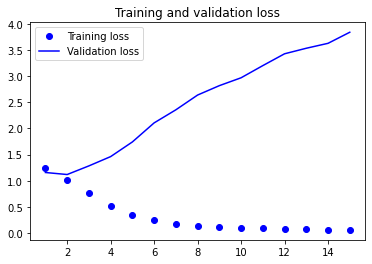

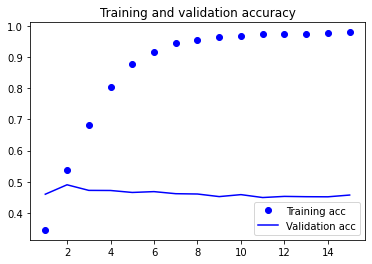

In [37]:
loss_emb = history_emb.history['loss']
val_loss_emb = history_emb.history['val_loss']
acc_emb = history_emb.history['accuracy']
val_acc_emb = history_emb.history['val_accuracy']


epochs_graph = range(1, len(acc_emb) + 1)

plt.plot(epochs_graph, loss_emb, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_emb, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_emb, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_emb, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# Fully Conneceted NN & Pre-Trained Embeddings Layer

In [38]:
glove_dir = os.path.join(home, nlp_repo, 'notebooks/02_processing/glove.6B')

In [39]:
embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [40]:
embedding_matrix = np.zeros((max_words+1, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
print(embedding_matrix.shape)

(10001, 100)


In [41]:
model_transf = models.Sequential()

model_transf.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_transf.add(layers.Flatten())
model_transf.add(layers.Dense(32, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(32, activation='relu'))
# model_transf.add(layers.Dropout(0.75))
model_transf.add(layers.Dense(dimensions_labels, activation='softmax'))

model_transf.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_transf.layers[0].trainable = False


# needed in order to save the weights: https://stackoverflow.com/questions/55908188/this-model-has-not-yet-been-built-error-on-model-summary
model_transf.build((max_len,))

model_transf.summary()


model_transf.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2500)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                80032     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 1,081,320
Trainable params: 81,220
Non-trainable params: 1,000,100
_________________________________________________________________


In [42]:
history_transf = model_transf.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

model_transf.save_weights(f'{model_path}_transf')

Epoch 1/15
431/431 [==============================] - 2s 4ms/step - loss: 1.2299 - accuracy: 0.4254 - precision: 0.5173 - recall: 0.1881 - val_loss: 1.1949 - val_accuracy: 0.4389 - val_precision: 0.5993 - val_recall: 0.1753
Epoch 2/15
431/431 [==============================] - 1s 2ms/step - loss: 1.0553 - accuracy: 0.5375 - precision: 0.6650 - recall: 0.3156 - val_loss: 1.1630 - val_accuracy: 0.4665 - val_precision: 0.5641 - val_recall: 0.2935
Epoch 3/15
431/431 [==============================] - 1s 2ms/step - loss: 0.9112 - accuracy: 0.6047 - precision: 0.7164 - recall: 0.4534 - val_loss: 1.1828 - val_accuracy: 0.4874 - val_precision: 0.5693 - val_recall: 0.3708
Epoch 4/15
431/431 [==============================] - 1s 2ms/step - loss: 0.7685 - accuracy: 0.6816 - precision: 0.7627 - recall: 0.5750 - val_loss: 1.2451 - val_accuracy: 0.4970 - val_precision: 0.5464 - val_recall: 0.3987
Epoch 5/15
431/431 [==============================] - 1s 2ms/step - loss: 0.6348 - accuracy: 0.7501 - pr

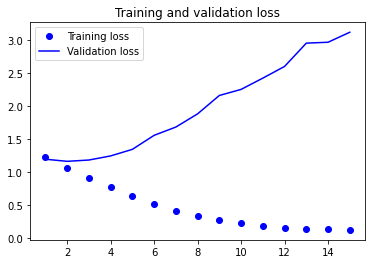

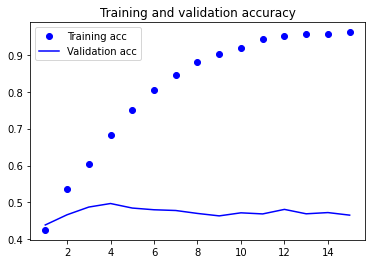

In [43]:
loss_transf = history_transf.history['loss']
val_loss_transf = history_transf.history['val_loss']
acc_transf = history_transf.history['accuracy']
val_acc_transf = history_transf.history['val_accuracy']


epochs_graph = range(1, len(acc_transf) + 1)

plt.plot(epochs_graph, loss_transf, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_transf, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_transf, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_transf, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# LSTM

In [44]:
model_lstm = models.Sequential()

model_lstm.add(layers.Embedding(max_words+1,
                                embedding_dim, input_length=max_len))

# model_lstm.add(layers.Flatten())
# Option 1
model_lstm.add(layers.LSTM(32))

# Option 2
# model.add(layers.LSTM(32, return_sequences=True)) # stacking of LSTMs
# model.add(layers.LSTM(32)) # the size of the hidden state, randomly defined
model_lstm.add(layers.Dense(32, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(32, activation='relu'))
# model_lstm.add(layers.Dropout(0.5))
model_lstm.add(layers.Dense(dimensions_labels, activation='softmax'))

model_lstm.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_lstm.layers[0].trainable = False

model_lstm.summary()

model_lstm.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                17024     
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 132       
Total params: 1,019,368
Trainable params: 19,268
Non-trainable params: 1,000,100
_________________________________________________________________


In [45]:
history_lstm = model_lstm.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 5s 11ms/step - loss: 1.2423 - accuracy: 0.4197 - precision: 0.5155 - recall: 0.1627 - val_loss: 1.1665 - val_accuracy: 0.4502 - val_precision: 0.5573 - val_recall: 0.1567
Epoch 2/15
431/431 [==============================] - 4s 9ms/step - loss: 1.1302 - accuracy: 0.4617 - precision: 0.6108 - recall: 0.1713 - val_loss: 1.1140 - val_accuracy: 0.4615 - val_precision: 0.5514 - val_recall: 0.2334
Epoch 3/15
431/431 [==============================] - 3s 8ms/step - loss: 1.0759 - accuracy: 0.4892 - precision: 0.6098 - recall: 0.2355 - val_loss: 1.0902 - val_accuracy: 0.4874 - val_precision: 0.5961 - val_recall: 0.2327
Epoch 4/15
431/431 [==============================] - 3s 8ms/step - loss: 1.0381 - accuracy: 0.5127 - precision: 0.6222 - recall: 0.2703 - val_loss: 1.0799 - val_accuracy: 0.4871 - val_precision: 0.6112 - val_recall: 0.2563
Epoch 5/15
431/431 [==============================] - 4s 9ms/step - loss: 0.9993 - accuracy: 0.5361 - p

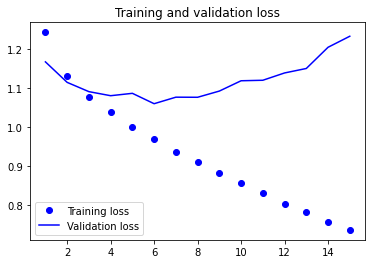

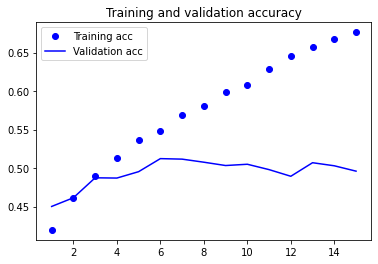

In [46]:
loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']
acc_lstm = history_lstm.history['accuracy']
val_acc_lstm = history_lstm.history['val_accuracy']


epochs_graph = range(1, len(acc_lstm) + 1)

plt.plot(epochs_graph, loss_lstm, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_lstm, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

# 1D Convolutional NN

In [47]:
model_conv1d = models.Sequential()

model_conv1d.add(layers.Embedding(max_words+1,
                                  embedding_dim, input_length=max_len))

model_conv1d.add(layers.Conv1D(
    32,  # features to be extracted
    5,  # convolutional window size
    activation='relu',
))
# model_conv1d.add(layers.MaxPooling1D(3))
model_conv1d.add(layers.Conv1D(32, 5, activation='relu'))
model_conv1d.add(layers.GlobalMaxPooling1D())
model_conv1d.add(layers.Dense(dimensions_labels, activation='softmax'))

model_conv1d.layers[0].set_weights([embedding_matrix])  # !!!! important !!!!
model_conv1d.layers[0].trainable = False

model_conv1d.summary()

model_conv1d.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=metrics
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 25, 100)           1000100   
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 32)            16032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 132       
Total params: 1,021,416
Trainable params: 21,316
Non-trainable params: 1,000,100
_________________________________________________________________


In [48]:
history_conv1d = model_conv1d.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/15
431/431 [==============================] - 1s 3ms/step - loss: 1.2587 - accuracy: 0.4151 - precision: 0.5507 - recall: 0.1604 - val_loss: 1.1924 - val_accuracy: 0.4326 - val_precision: 0.5983 - val_recall: 0.1444
Epoch 2/15
431/431 [==============================] - 1s 3ms/step - loss: 1.1121 - accuracy: 0.4927 - precision: 0.6344 - recall: 0.2362 - val_loss: 1.1666 - val_accuracy: 0.4376 - val_precision: 0.5645 - val_recall: 0.2151
Epoch 3/15
431/431 [==============================] - 1s 3ms/step - loss: 1.0258 - accuracy: 0.5476 - precision: 0.6770 - recall: 0.3268 - val_loss: 1.1905 - val_accuracy: 0.4412 - val_precision: 0.5499 - val_recall: 0.2669
Epoch 4/15
431/431 [==============================] - 1s 3ms/step - loss: 0.9389 - accuracy: 0.6018 - precision: 0.7082 - recall: 0.4145 - val_loss: 1.1578 - val_accuracy: 0.4631 - val_precision: 0.5308 - val_recall: 0.3118
Epoch 5/15
431/431 [==============================] - 1s 3ms/step - loss: 0.8663 - accuracy: 0.6385 - pr

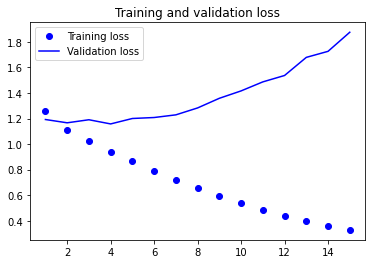

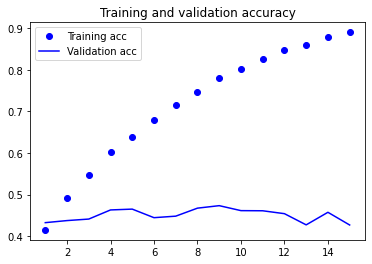

In [49]:
loss_conv1d = history_conv1d.history['loss']
val_loss_conv1d = history_conv1d.history['val_loss']
acc_conv1d = history_conv1d.history['accuracy']
val_acc_conv1d = history_conv1d.history['val_accuracy']


epochs_graph = range(1, len(acc_conv1d) + 1)

plt.plot(epochs_graph, loss_conv1d, 'bo', label='Training loss')
plt.plot(epochs_graph, val_loss_conv1d, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

plt.plot(epochs_graph, acc_conv1d, 'bo', label='Training acc')
plt.plot(epochs_graph, val_acc_conv1d, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

With a hold-out validation and wihtout any regularisation a full connected NN with an Embedding layer seems to have the best performance on the training set. 
However, it is highly overfitting. This is the better case, as with regularization we can try to fix the issue. 

Before that, though, I am going to evaluate the models with cross-validation due to the low volume of data we have.

In [50]:
def with_cross_val(k, model, train_data, train_targets, epochs, batch_size):
    """
    This function applies a k-fold cross-validation.
    Args: 
        - k - number of folds
        - model - which model is to be used
        - train_data - the tokenised, padded and shuffled sequences
        - train_targets - labels 
        - epochs - number of epochs
        - batch_size - batch size

    Returns:
        - all_histories_acc - accuracy for all epochs and folds
        - all_histories_prec - precision for all epochs and folds
        - all_histories_rec - recall for all epochs and folds

    """
    num_val_samples = len(train_data) // k
    all_histories_acc = []
    all_histories_prec = []
    all_histories_rec = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
        val_targets = train_targets[i *
                                    num_val_samples:(i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_data[:i * num_val_samples],
             train_data[(i + 1) * num_val_samples:]],
            axis=0)

        partial_train_targets = np.concatenate(
            [train_targets[:i * num_val_samples],
             train_targets[(i + 1) * num_val_samples:]],
            axis=0
        )

        #model = build_model()
        history = model.fit(
            partial_train_data, partial_train_targets,
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            validation_data=(val_data, val_targets)
        )

        metric_history_acc = history.history['val_accuracy']
        all_histories_acc.append(metric_history_acc)

        metric_history_prec = history.history['val_precision']
        all_histories_prec.append(metric_history_prec)

        metric_history_rec = history.history['val_recall']
        all_histories_rec.append(metric_history_rec)

    return all_histories_acc, all_histories_prec, all_histories_rec

In [51]:
all_histories_acc_bow, all_histories_prec_bow, all_histories_rec_bow = with_cross_val(
    k=4,
    model=model_bow,
    train_data=data_oh,
    train_targets=labels_encoded_oh,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [52]:
average_acc_history_bow = [
    np.mean([x[i] for x in all_histories_acc_bow]) for i in range(epochs)]
average_acc_history_bow[-1]

0.44442231208086014

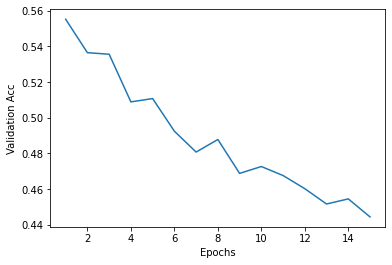

In [53]:
plt.plot(range(1, len(average_acc_history_bow) + 1), average_acc_history_bow)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [54]:
all_histories_acc_emb, all_histories_prec_emb, all_histories_rec_emb = with_cross_val(
    k=4,
    model=model_emb,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [55]:
average_acc_history_emb = [
    np.mean([x[i] for x in all_histories_acc_emb]) for i in range(epochs)]
average_acc_history_emb[-1]

0.8845285475254059

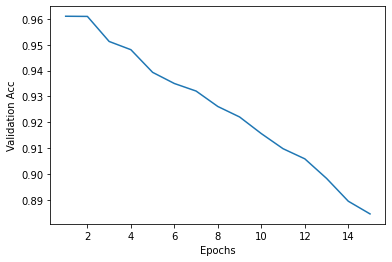

In [56]:
plt.plot(range(1, len(average_acc_history_emb) + 1), average_acc_history_emb)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [57]:
all_histories_acc_transf, all_histories_prec_transf, all_histories_rec_transf = with_cross_val(
    k=4,
    model=model_transf,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [58]:
average_acc_history_transf = [
    np.mean([x[i] for x in all_histories_acc_transf]) for i in range(epochs)]
average_acc_history_transf[-1]

0.8604913651943207

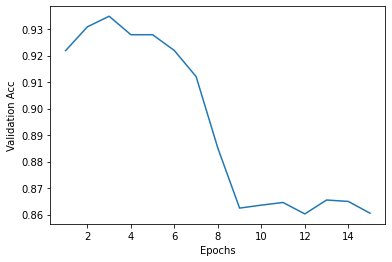

In [59]:
plt.plot(range(1, len(average_acc_history_transf) + 1),
         average_acc_history_transf)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [60]:
all_histories_acc_lstm, all_histories_prec_lstm, all_histories_rec_lstm = with_cross_val(
    k=4,
    model=model_lstm,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [61]:
average_acc_history_lstm = [
    np.mean([x[i] for x in all_histories_acc_lstm]) for i in range(epochs)]
average_acc_history_lstm[-1]

0.7008632272481918

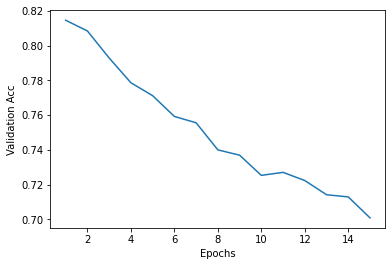

In [62]:
plt.plot(range(1, len(average_acc_history_lstm) + 1), average_acc_history_lstm)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

In [63]:
all_histories_acc_conv1d, all_histories_prec_conv1d, all_histories_rec_conv1d = with_cross_val(
    k=4,
    model=model_conv1d,
    train_data=data_ovs,
    train_targets=labels_encoded,
    epochs=epochs,
    batch_size=batch_size)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [64]:
average_acc_history_conv1d = [
    np.mean([x[i] for x in all_histories_acc_conv1d]) for i in range(epochs)]
average_acc_history_conv1d[-1]

0.7660026550292969

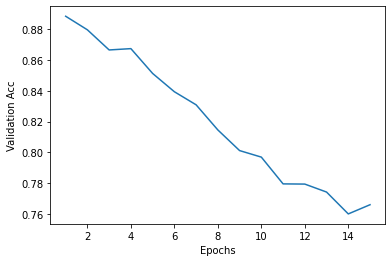

In [65]:
plt.plot(range(1, len(average_acc_history_conv1d) + 1),
         average_acc_history_conv1d)
plt.xlabel('Epochs')
plt.ylabel('Validation Acc')
plt.show()

This time on the validation set - the results are drammatically improved. However, the fully connected NN with Embedding Layer still has the best performance. 